In [ ]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score

# Load CSV datasets
train_data = pd.read_csv("BATADAL_dataset04.csv")
test_data  = pd.read_csv("BATADAL_test_dataset.csv")

# Convert the first column (timestamp) to datetime and extract features
for df in [train_data, test_data]:
    df['timestamp'] = pd.to_datetime(df.iloc[:, 0], format='%d/%m/%y %H')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    # Replace -999 in the attack flag (last column) with 0
    df.iloc[:, -1] = df.iloc[:, -1].replace(-999, 0)
    # Drop the timestamp column
    df.drop(columns=[df.columns[0]], inplace=True)

# Define features and labels (drop 'timestamp' and the attack flag)
X_train_df = train_data.drop(columns=['timestamp', train_data.columns[-1]])
y_train    = train_data.iloc[:, -1].values
X_test_df  = test_data.drop(columns=['timestamp', test_data.columns[-1]])
y_test     = test_data.iloc[:, -1].values

# Clean column names and ensure same order
X_train_df.columns = X_train_df.columns.str.strip()
X_test_df.columns  = X_test_df.columns.str.strip()
common_cols = list(set(X_train_df.columns) & set(X_test_df.columns))
X_train_df = X_train_df[common_cols]
X_test_df  = X_test_df[common_cols]

# Normalize features
scaler = MinMaxScaler()
X_train_df[X_train_df.columns] = scaler.fit_transform(X_train_df[X_train_df.columns])
X_test_df[X_test_df.columns]   = scaler.transform(X_test_df[X_test_df.columns])

print("Sample training data:")
print(X_train_df.head())
print("\ny_train:", y_train)
print(y_train[:10])
print("\nSample testing data:")
print(X_test_df.head())
print("\ny_test:", y_test)
print(y_test[:10])

print("\nX_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)
print("Number of features:", X_train_df.shape[1])

# Count the number of 0's and 1's in y_train
num_zeros_train = (y_train == 0).sum()
num_ones_train = (y_train == 1).sum()

# Count the number of 0's and 1's in y_test
num_zeros_test = (y_test == 0).sum()
num_ones_test = (y_test == 1).sum()

# Print the results
print("\nTraining dataset:")
print("Number of 0's:", num_zeros_train)
print("Number of 1's:", num_ones_train)

print("\nTesting dataset:")
print("Number of 0's:", num_zeros_test)
print("Number of 1's:", num_ones_test)

Sample training data:
       L_T5      L_T3    P_J307  S_PU10  S_PU1  F_V2      L_T2  S_PU7  \
0  0.548611  0.121569  0.138159     1.0    0.0   0.0  0.919776    1.0   
1  0.697917  0.125490  0.281364     0.0    0.0   0.0  0.787313    1.0   
2  0.899306  0.305882  0.282060     0.0    0.0   0.0  0.625000    1.0   
3  0.791667  0.505882  0.310249     1.0    0.0   0.0  0.509328    0.0   
4  0.635417  0.725490  0.322429     1.0    0.0   0.0  0.442164    0.0   

   ATT_FLAG      L_T4  ...  F_PU11    P_J415  F_PU5     P_J14    P_J317  \
0       0.0  0.784173  ...     0.0  0.591187    0.0  0.232103  0.486295   
1       0.0  0.812950  ...     0.0  0.572672    0.0  0.289373  0.197306   
2       0.0  0.823741  ...     0.0  0.614146    0.0  0.285945  0.167533   
3       0.0  0.762590  ...     0.0  0.274208    0.0  0.310950  0.493620   
4       0.0  0.460432  ...     0.0  0.274023    0.0  0.326275  0.499055   

   F_PU6    P_J306     F_PU4    P_J289     F_PU8  
0    0.0  0.662634  0.000000  0.59189

In [ ]:
# Define the 20 sensor nodes
sensor_nodes = ["L_T1", "F_PU8", "P_J269", "P_J302", "P_J317",
                "F_PU1", "F_V2", "P_J14", "P_J300", "P_J289",
                "P_J415", "F_PU7", "F_PU6", "P_J306", "F_PU4",
                "F_PU5", "P_J256", "P_J307", "P_J422", "P_T7"]

# Determine which columns are sensor readings vs. global features
sensor_columns = [col for col in X_train_df.columns if col in sensor_nodes]
global_columns = [col for col in X_train_df.columns if col not in sensor_columns]

print("Sensor columns:", sensor_columns)
print("Global columns:", global_columns)

# Function to build node features for each sample (graph)
def construct_node_features(df, sensor_cols, global_cols, nodes_order):
    num_nodes = len(nodes_order)
    feature_dim = 1 + len(global_cols)  # one sensor reading + global features
    X_nodes = []
    for _, row in df.iterrows():
        node_feats = []
        for node in nodes_order:
            sensor_val = row[node] if node in sensor_cols else 0.0
            global_vals = row[global_cols].values.tolist() if global_cols else []
            node_feats.append([sensor_val] + global_vals)
        X_nodes.append(node_feats)
    return np.array(X_nodes, dtype=np.float32)

X_train_nodes = construct_node_features(X_train_df, sensor_columns, global_columns, sensor_nodes)
X_test_nodes  = construct_node_features(X_test_df, sensor_columns, global_columns, sensor_nodes)

print("X_train_nodes shape:", X_train_nodes.shape)  # e.g. (4177, 20, feature_dim)
print("X_test_nodes shape:", X_test_nodes.shape)

Sensor columns: ['P_J307', 'F_V2', 'P_J256', 'P_J422', 'L_T1', 'P_J269', 'F_PU1', 'P_J302', 'F_PU7', 'P_J300', 'P_J415', 'F_PU5', 'P_J14', 'P_J317', 'F_PU6', 'P_J306', 'F_PU4', 'P_J289', 'F_PU8']
Global columns: ['L_T5', 'L_T3', 'S_PU10', 'S_PU1', 'L_T2', 'S_PU7', 'ATT_FLAG', 'L_T4', 'F_PU9', 'F_PU2', 'F_PU10', 'hour', 'L_T7', 'S_PU2', 'S_PU6', 'S_PU4', 'S_V2', 'day_of_week', 'P_J280', 'S_PU9', 'S_PU5', 'S_PU11', 'S_PU3', 'L_T6', 'F_PU3', 'S_PU8', 'F_PU11']
X_train_nodes shape: (4177, 20, 28)
X_test_nodes shape: (2089, 20, 28)


Adjacency Matrix A:
[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 

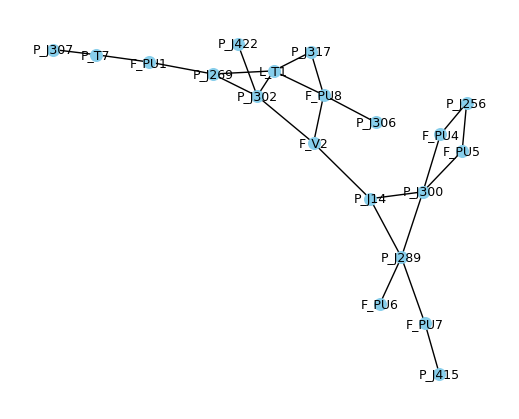

In [ ]:
# Build a fixed adjacency matrix from the given edge list.
edges = [
    ("P_J415", "F_PU7"),
    ("F_PU7", "P_J289"),
    ("F_PU6", "P_J289"),
    ("P_J289", "P_J300"),
    ("P_J300", "P_J14"),
    ("P_J289", "P_J14"),
    ("P_J289", "P_J14"),
    ("P_J300", "F_PU4"),
    ("P_J300", "F_PU5"),
    ("F_PU4", "P_J256"),
    ("F_PU5", "P_J256"),
    ("P_J14", "F_V2"),
    ("F_V2", "P_J302"),
    ("P_J302", "P_J269"),
    ("P_J269", "F_PU1"),
    ("F_PU1", "P_T7"),
    ("P_T7", "P_J307"),
    ("P_J302", "P_J422"),
    ("P_J269", "L_T1"),
    ("P_J302", "L_T1"),
    ("L_T1", "F_PU8"),
    ("L_T1", "P_J317"),
    ("F_V2", "F_PU8"),
    ("F_PU8", "P_J306"),
    ("F_PU8", "P_J317")
]

G = nx.Graph()
G.add_edges_from(edges)
# Make sure the ordering of nodes matches sensor_nodes
A = nx.to_numpy_array(G, nodelist=sensor_nodes).astype(np.float32)

print("Adjacency Matrix A:")
print(A)

plt.figure(figsize=(5, 4))
nx.draw(G, with_labels=True, node_color="skyblue", node_size=70, font_size=9)
plt.show()

# Since the same adjacency matrix is used for every sample, we tile it accordingly.
adj_tiled_train = np.tile(A, (X_train_nodes.shape[0], 1, 1))
adj_tiled_test  = np.tile(A, (X_test_nodes.shape[0], 1, 1))

# Convert labels to float32 for binary crossentropy
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_nodes, adj_tiled_train), y_train))
test_ds  = tf.data.Dataset.from_tensor_slices(((X_test_nodes, adj_tiled_test), y_test))

batch_size = 50
train_ds = train_ds.shuffle(1000).batch(batch_size)
test_ds  = test_ds.batch(batch_size)

In [ ]:
# Custom GCN Layer
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation='relu', dropout_rate=0.0):
        super(GCNLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate # Store dropout_rate
        self.dropout = Dropout(dropout_rate) # Create Dropout layer

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[0][-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=None): # Add training argument
        X, A = inputs
        XW = tf.matmul(X, self.w)
        AXW = tf.matmul(A, XW) + self.b

        # Apply dropout
        AXW = self.dropout(AXW, training=training)

        return self.activation(AXW)


def build_model():
       X_in = Input(shape=(20, X_train_nodes.shape[-1]), name="X_in")
       A_in = Input(shape=(20, 20), name="A_in")

       # First GCN layer
       gcn1 = GCNLayer(32, dropout_rate=0.5)([X_in, A_in])

       # Second GCN layer
       gcn2 = GCNLayer(32, dropout_rate=0.5)([gcn1, A_in])

       pooled = GlobalAveragePooling1D()(gcn2)  # Pooling after the last GCN layer
       output = Dense(1, activation='sigmoid')(pooled)
       model = Model(inputs=[X_in, A_in], outputs=output)
       return model

model = build_model()

# Calculate class weights
neg, pos = np.bincount(y_train.astype(int))
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Compile the model
model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

In [ ]:
# Train with early stopping
early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True)
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[early_stopping],
)

# Evaluate with a fixed threshold
y_probs = model.predict(test_ds).ravel()
y_pred = (y_probs >= 0.5).astype(int)

# Calculate the False Positives (FP) and True Negatives (TN)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
false_alarm_rate = fp / (fp + tn)

# Metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_probs))
print("False Alarm Rate:", false_alarm_rate)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7248 - auc: 0.5720 - loss: 0.7009 - precision: 0.4429 - recall: 0.1071 - val_accuracy: 0.8593 - val_auc: 0.8950 - val_loss: 3.1097 - val_precision: 0.7504 - val_recall: 0.7348
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8800 - auc: 0.9511 - loss: 0.2634 - precision: 0.8314 - recall: 0.7124 - val_accuracy: 0.9014 - val_auc: 0.9462 - val_loss: 3.8517 - val_precision: 0.9245 - val_recall: 0.7002
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9240 - auc: 0.9787 - loss: 0.1744 - precision: 0.8536 - recall: 0.8672 - val_accuracy: 0.9258 - val_auc: 0.9645 - val_loss: 4.8096 - val_precision: 0.9731 - val_recall: 0.7522
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9416 - auc: 0.9856 - loss: 0.1438 - precision: 0.8842 - recall: 0.9064 - val_accuracy: 0.9014 - val_auc: 0.9682 - val_loss: 5.5603 - val_precision: 1.0000 - val_recall: 0.6430
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1